In [3]:
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import cv2

In [4]:
files = glob.glob("imagesTr//pancreas_"+"*.nii",recursive=True)

In [5]:
len(files)

281

In [20]:
ornek = files[46]

simpleitk tıbbı, ct, mr gibi görüntüleri incelemek için özel olarak hazırlanmış bir plugin


In [21]:
img = io.imread(ornek,plugin="simpleitk")

In [22]:
img.shape

(97, 512, 512)

In [23]:
img.dtype

dtype('float32')

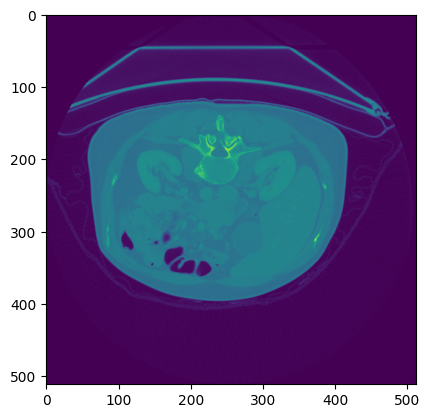

In [32]:
plt.imshow(img[40,:,:])

In [33]:
img_seg =io.imread('LabelsTr//pancreas_046.nii',plugin="simpleitk")

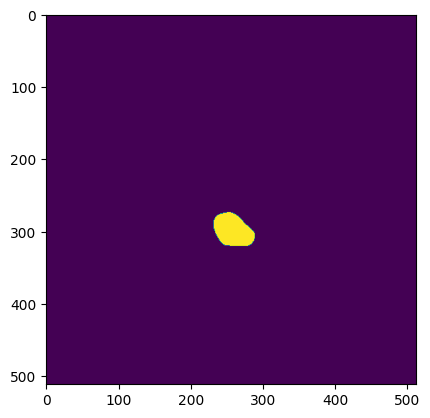

In [34]:
plt.imshow(img_seg[40,:,:])

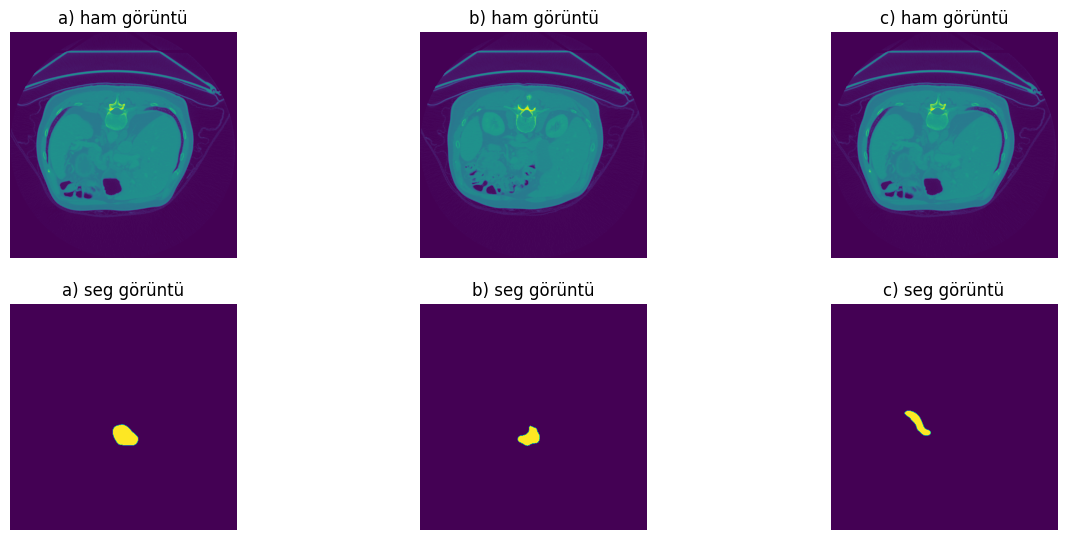

In [38]:
plt.figure(figsize=(15,10))

plt.subplot(3,3,3)
plt.title('c) ham görüntü')
plt.axis('off')
plt.imshow(img[60,:,:,])

plt.subplot(3,3,2)
plt.title('b) ham görüntü')
plt.axis('off')
plt.imshow(img[50,:,:])

plt.subplot(3,3,1)
plt.title('a) ham görüntü')
plt.axis('off')
plt.imshow(img[60,:,:])

plt.subplot(3,3,6)
plt.title('c) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[60,:,:,])

plt.subplot(3,3,5)
plt.title('b) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[50,:,:])

plt.subplot(3,3,4)
plt.title('a) seg görüntü')
plt.axis('off')
plt.imshow(img_seg[40,:,:])

In [48]:
import numpy as np
import random as r
import gc; gc.enable() 

def train_array(path,end):
    files = glob.glob(path+end,recursive=True) 
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files[70:130] :
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/img.std() 
        img.astype('float32')
        
        
        for slice in range(80,110):
            img_s = img[:,:] 
            #img_s = np.expand_dims(img_s)
                                                
            img_liste.append(img_s)
    return np.array(img_liste,np.float32)

In [49]:
path="imagesTr//"
end="**//*.nii"

In [50]:
train = train_array(path,end)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1800,) + inhomogeneous part.

In [42]:
def return2rgb(train):
    new_train = []
    for i in train:
        a = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB)
        new_train.append(a)
    return np.array(new_train,np.float32)

In [43]:
new_train = return2rgb(train)
new_train.shape

NameError: name 'train' is not defined

In [21]:
import numpy as np
import random as r
import gc; gc.enable()

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True) 
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files[70:130] :
        img = io.imread(file,plugin='simpleitk') 
        
        if label == 1:
            img[img != 0] = 1 # Tam tümör
        if label == 2:
            img[img != 1] = 0 # Nekroz
        if label == 3:
            img[img == 2] = 0 # Ödemsiz tümör
            img[img != 0] = 1 
        if label == 4:
            img[img != 4] = 0 # Genişleyen tümör
            img[img == 4] = 1 
            
        img.astype('float32')
        
    
        for slice in range(80,110):
            img_s = img[slice,:,:] 
            #img_s = np.expand_dims(img_s,axis=0)
                                                
            img_liste.append(img_s)
    print("img.shape",img.shape)
    return np.array(img_liste,np.float32)

In [22]:
path="BraTS2021_Training_Data_Son//"
end="**//*seg.nii"

In [23]:
seg_tam = seg_array(path,end,1)
seg_nekroz = seg_array(path,end,2)
seg_ödemsiz = seg_array(path,end,3)
seg_geniş = seg_array(path,end,4)
seg_orj = seg_array(path,end,0)

img.shape (155, 240, 240)
img.shape (155, 240, 240)
img.shape (155, 240, 240)
img.shape (155, 240, 240)
img.shape (155, 240, 240)


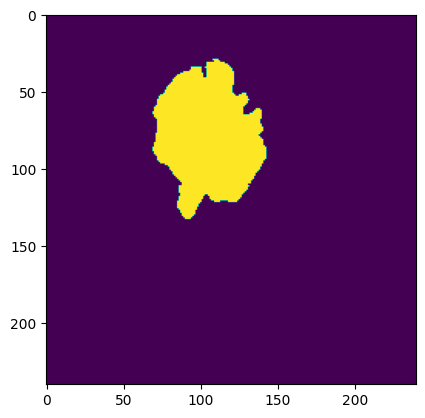

In [24]:
a = seg_tam[1352]
a = a.reshape(240,240,1)
plt.imshow(a)

Text(0.5, 1.0, 'ham görüntü')

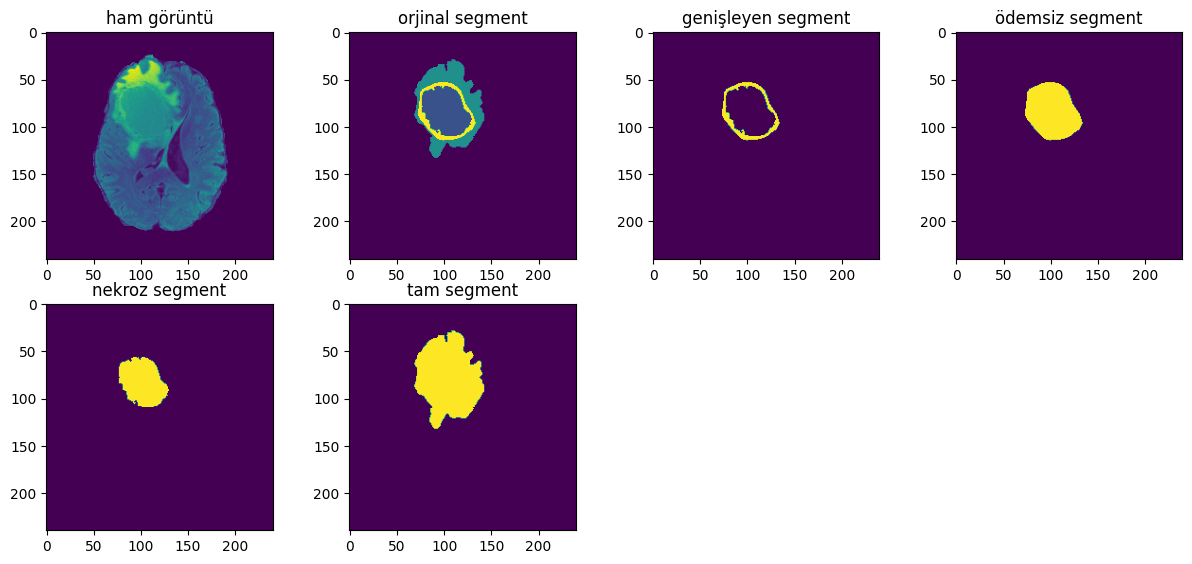

In [25]:
x=1352

plt.figure(figsize=(15,10))

plt.subplot(3,4,6)
plt.imshow(seg_tam[x].reshape(240,240))
plt.title("tam segment")

plt.subplot(3,4,5)
plt.imshow(seg_nekroz[x].reshape(240,240))
plt.title("nekroz segment")

plt.subplot(3,4,4)
plt.imshow(seg_ödemsiz[x].reshape(240,240))
plt.title("ödemsiz segment")

plt.subplot(3,4,3)
plt.imshow(seg_geniş[x].reshape(240,240))
plt.title("genişleyen segment")

plt.subplot(3,4,2)
plt.imshow(seg_orj[x].reshape(240,240))
plt.title("orjinal segment")

plt.subplot(3,4,1)
plt.imshow(train[x].reshape(240,240))
plt.title("ham görüntü")

In [26]:
flair = train_array("BraTS2021_Training_Data_Son//","**//*flair.nii")
seg   = seg_array("BraTS2021_Training_Data_Son//","**//*seg.nii",1)

img.shape (155, 240, 240)


In [27]:
seg.shape

(1800, 240, 240)

In [28]:
x_train = return2rgb(flair)

In [29]:
x_train.shape

(1800, 240, 240, 3)

In [31]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model,save_model
from tensorflow.keras.layers import (Input, Activation,
                                     BatchNormalization, 
                                     Dropout, Lambda, Conv2D,
                                     Conv2DTranspose, MaxPooling2D,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
K.set_image_data_format('channels_last')

def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Jaccard Distance
def iou(y_true, y_pred):
    smooth=100
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth)/(sum_ - intersection + smooth)
    
    return jac

def jac_distance(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    return 1-iou(y_true, y_pred)

In [33]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer(inputs.name).output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output ## 128
    s4 = densenet.get_layer("pool3_relu").output  ## 64

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)             ## 64
    d2 = decoder_block(d1, s3, 256)             ## 128
    d3 = decoder_block(d2, s2, 128)             ## 256
    d4 = decoder_block(d3, s1, 64)              ## 512

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

In [35]:
WIDTH = HEIGHT = 240

In [36]:
EPOCHS = 70
BATCH_SIZE = 8
ALPHA = 0.00005 # learning rate
DECAY_RATE = ALPHA/EPOCHS

In [40]:
from tensorflow.keras.optimizers.legacy import Adam
input_size=(HEIGHT, WIDTH, 3)
model = build_densenet121_unet(input_size)
OPTIMIZER = Adam(learning_rate=ALPHA, epsilon=None, decay=DECAY_RATE)

model.compile(loss=dice_coef_loss,
                       optimizer = OPTIMIZER,
                      metrics=['binary_accuracy', iou,dice_coef])

In [41]:
# Saving Models
callbacks = [ModelCheckpoint('densenet1_unet.hdf5',
                             verbose=1,
                             save_best_only=True)]

In [42]:
history = model.fit(x_train,
                    seg,
                   steps_per_epoch=len(x_train)/BATCH_SIZE,
                   epochs=EPOCHS,
                   callbacks= callbacks)

Epoch 1/70
225/225 [==============================] - 295s 1s/step - loss: 0.7488 - binary_accuracy: 0.9285 - iou: 0.1492 - dice_coef: 0.2512
Epoch 2/70
225/225 [==============================] - 293s 1s/step - loss: 0.6106 - binary_accuracy: 0.9946 - iou: 0.2465 - dice_coef: 0.3894
Epoch 3/70
225/225 [==============================] - 290s 1s/step - loss: 0.5391 - binary_accuracy: 0.9964 - iou: 0.3071 - dice_coef: 0.4609
Epoch 4/70
225/225 [==============================] - 290s 1s/step - loss: 0.4642 - binary_accuracy: 0.9973 - iou: 0.3738 - dice_coef: 0.5358
Epoch 5/70
225/225 [==============================] - 291s 1s/step - loss: 0.3884 - binary_accuracy: 0.9980 - iou: 0.4483 - dice_coef: 0.6116
Epoch 6/70
225/225 [==============================] - 292s 1s/step - loss: 0.3246 - binary_accuracy: 0.9984 - iou: 0.5185 - dice_coef: 0.6754
Epoch 7/70
225/225 [==============================] - 290s 1s/step - loss: 0.2682 - binary_accuracy: 0.9986 - iou: 0.5848 - dice_coef: 0.7318
Epoch 

In [43]:
score = model.evaluate(x=x_train,y=seg,batch_size=32)
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

57/57 [==============================] - 86s 1s/step - loss: 0.0308 - binary_accuracy: 0.9997 - iou: 0.9821 - dice_coef: 0.9565
Score Accuracy : 99.97%


In [44]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'iou', 'dice_coef'])


In [45]:
model.save_weights("brain_tumor_denseunet.h5")

In [46]:
model.load_weights("./brain_tumor_denseunet.h5")

Text(0, 0.5, 'Yüzde(%)')

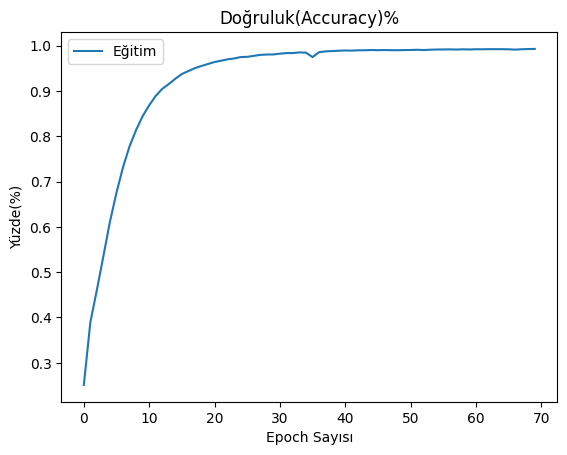

In [48]:
plt.plot(history.history['dice_coef'])
#plt.plot(history.history['val_dice_coef'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk(Accuracy)%')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Yüzde(%)')

Text(0, 0.5, 'Yüzde(%)')

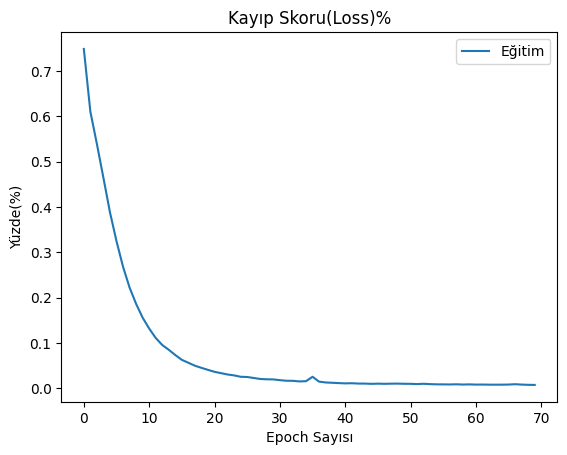

In [49]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp Skoru(Loss)%')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Yüzde(%)')

1/1 [==============================] - 1s 566ms/step


Text(0.5, 1.0, 'Modelin segmentasyon')

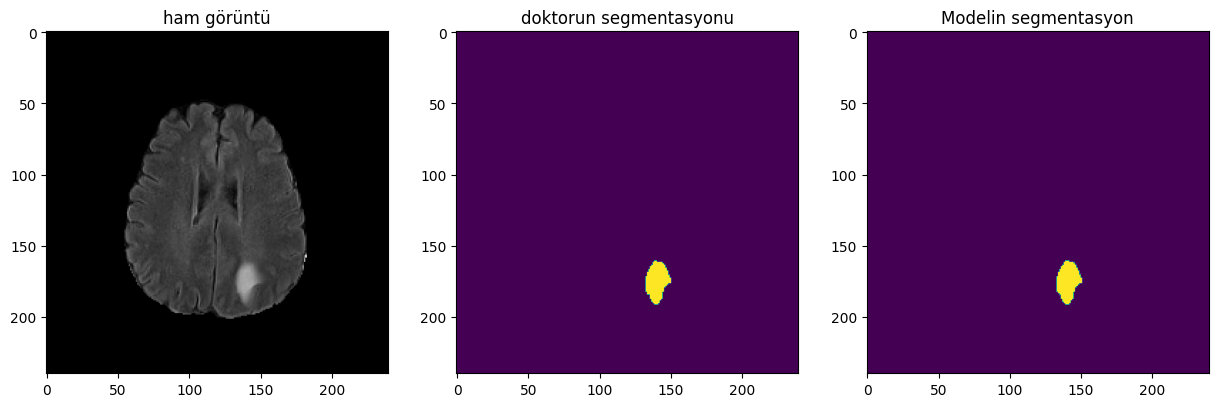

In [50]:
x = 15
örnek = x_train[x]
örnek = np.expand_dims(x_train[x],axis=0)
örnek.shape

pred = model.predict(örnek)


plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(train[x],cmap='gray')
plt.title("ham görüntü")

plt.subplot(1,3,2)
plt.imshow(seg[x].reshape(240,240))
plt.title("doktorun segmentasyonu")

plt.subplot(1,3,3)
plt.imshow(pred.reshape(240,240))
plt.title("Modelin segmentasyon")

In [51]:
def test_array(file):
    img = io.imread(file,as_gray=True) # görüntüleri okuyoruz
    img = cv2.resize(img,(256,256))
    #img = img.transpose(2,0,1)
    img = (img-img.mean())/img.std() # standartize ediyoruz
    #img = img[1,:,:]
    img = np.expand_dims(img,axis=0)
    img.astype('float32')
    return img

def test_seg_array(file):
    img = io.imread(file,as_gray=True) # görüntüleri okuyoruz
    img = cv2.resize(img,(256,256))
    img.astype('float32')
    img = np.expand_dims(img,axis=0)
    return img

1/1 [==============================] - 0s 69ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


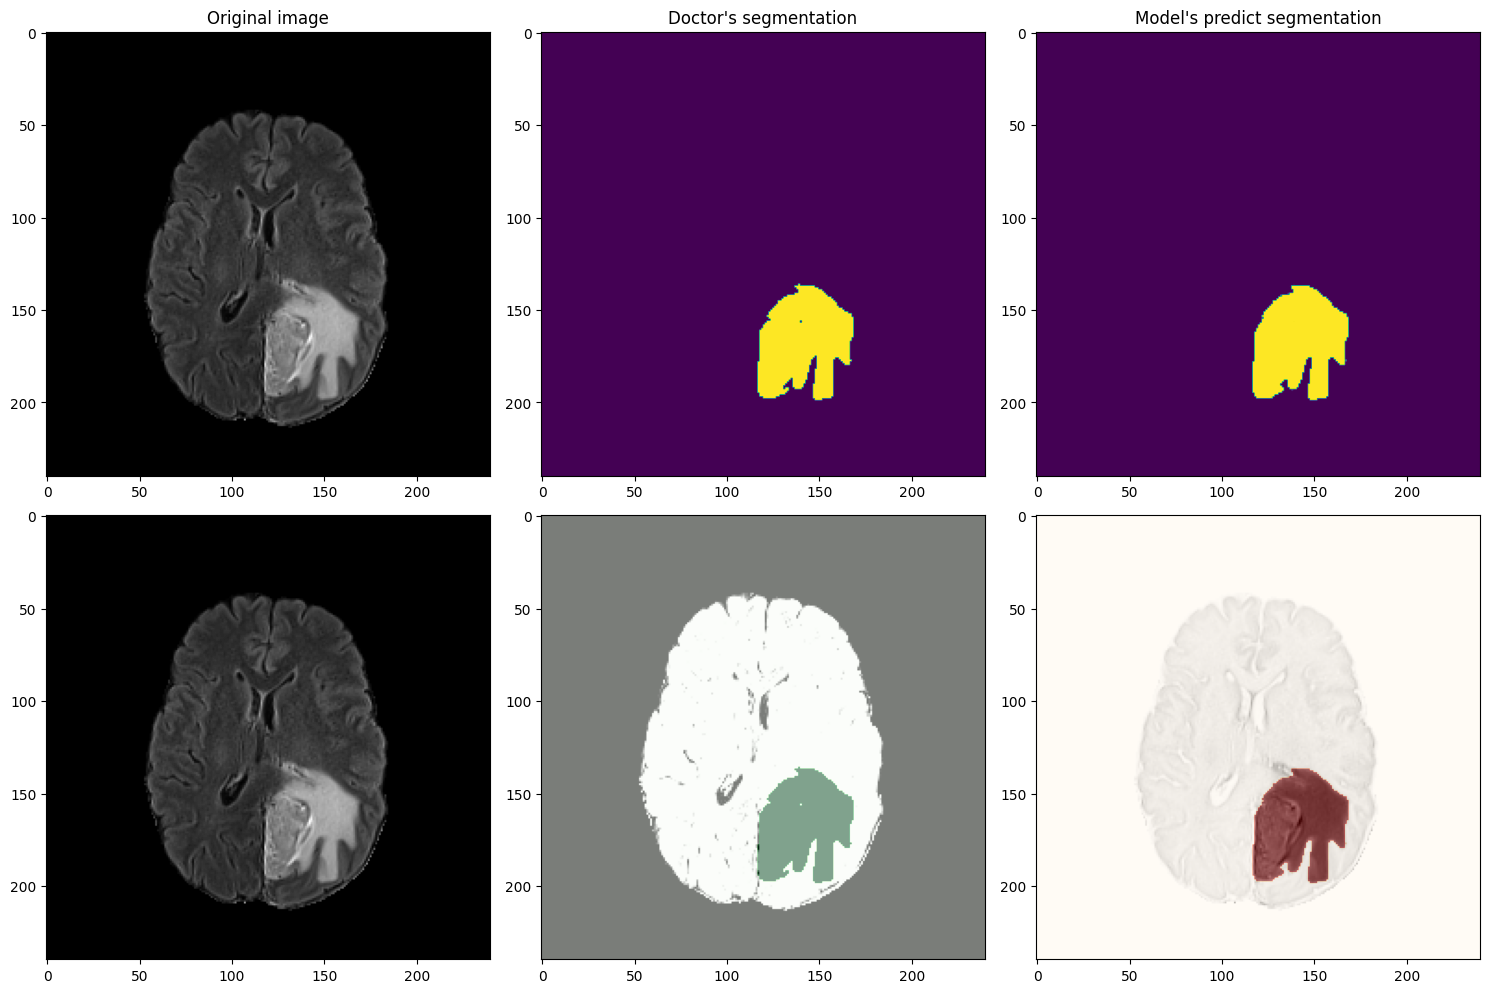

In [52]:
test = x_train[30]
test_t = train[30]
test_seg = seg[30]

örnek = test.copy()
örnek = np.expand_dims(örnek,axis=0)


pred = model.predict(örnek)



plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(test_t,cmap='gray')
plt.title("Original image")


plt.subplot(2,3,2)
plt.imshow(test_seg.reshape(240,240))
plt.title("Doctor's segmentation")


plt.subplot(2,3,3)
plt.imshow(pred.reshape(240,240))
plt.title("Model's predict segmentation")


plt.subplot(234)
plt.imshow(test_t,cmap='gray')


plt.subplot(235)
plt.imshow(test.squeeze(), cmap="Greys")
plt.imshow(test_seg.reshape(240,240).squeeze(), alpha=0.5, cmap="Greens")


plt.subplot(236)
plt.imshow(test_t,cmap="Greys")
plt.imshow(pred.reshape(240,240).squeeze(), alpha=0.5, cmap="OrRd")


plt.tight_layout()

plt.show()